# Data Preprocessing for Chess Dataset
This notebook demonstrates preprocessing steps for a chess game dataset.

In [18]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mstats, skew, kurtosis
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
import joblib

In [19]:
# Load dataset
data_df = pd.read_csv('games.csv', index_col=False)

In [20]:
# Rename columns for easier reference
data_df.columns = [
    'Game_ID', 'Rated_(T/F)', 'Start_Time', 'End_Time', 
    'Number_of_Turns', 'Game_Status', 'Winner', 'Time_Increment',
    'White_ID', 'White_Rating', 'Black_ID',
    'Black_Rating', 'Moves',
    'Opening_Eco', 'Opening_Name', 'Opening_Ply'
]

In [21]:
# Print the shape and summary information of the dataset
print(data_df.shape)
data_df.info()

(20058, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Game_ID          20058 non-null  object 
 1   Rated_(T/F)      20058 non-null  bool   
 2   Start_Time       20058 non-null  float64
 3   End_Time         20058 non-null  float64
 4   Number_of_Turns  20058 non-null  int64  
 5   Game_Status      20058 non-null  object 
 6   Winner           20058 non-null  object 
 7   Time_Increment   20058 non-null  object 
 8   White_ID         20058 non-null  object 
 9   White_Rating     20058 non-null  int64  
 10  Black_ID         20058 non-null  object 
 11  Black_Rating     20058 non-null  int64  
 12  Moves            20058 non-null  object 
 13  Opening_Eco      20058 non-null  object 
 14  Opening_Name     20058 non-null  object 
 15  Opening_Ply      20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
me

In [22]:
outliers = pd.DataFrame(columns=data_df.columns)

# Identify outliers and store them in 'outliers'
for column in data_df.select_dtypes(include=[float, int]).columns:
    z_scores = stats.zscore(data_df[column])
    outliers[column] = data_df[column][(z_scores > 4) | (z_scores < -4)]

# Remove outliers from the original DataFrame
for column in data_df.select_dtypes(include=[float, int]).columns:
    z_scores = stats.zscore(data_df[column])
    data_df = data_df[(z_scores <= 4) & (z_scores >= -4)]

# Display the count of outliers per column
print(outliers.notnull().sum())

Game_ID             0
Rated_(T/F)         0
Start_Time          0
End_Time            0
Number_of_Turns    31
Game_Status         0
Winner              0
Time_Increment      0
White_ID            0
White_Rating        0
Black_ID            0
Black_Rating        0
Moves               0
Opening_Eco         0
Opening_Name        0
Opening_Ply         0
dtype: int64


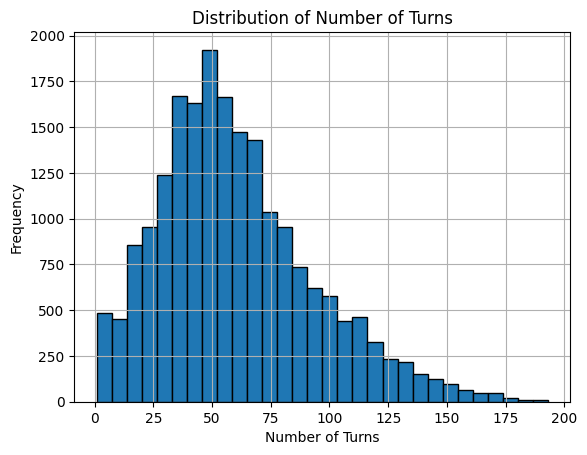

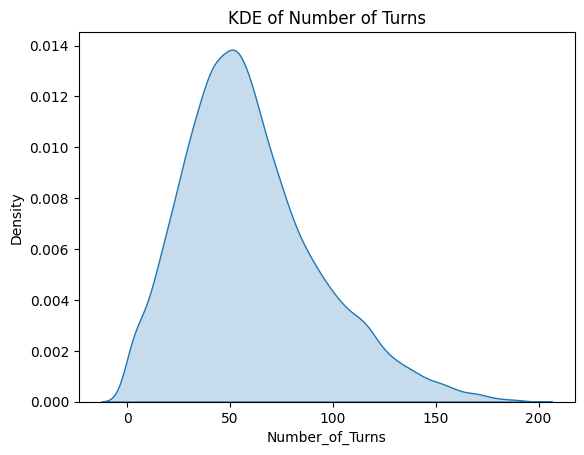

In [23]:
# Visualize distribution of 'Number_of_Turns'
data_df['Number_of_Turns'].hist(bins=30, edgecolor='black')
plt.title('Distribution of Number of Turns')
plt.xlabel('Number of Turns')
plt.ylabel('Frequency')
plt.show()

# Kernel Density Estimation (KDE) plot for 'Number_of_Turns'
sns.kdeplot(data_df['Number_of_Turns'], fill=True)
plt.title('KDE of Number of Turns')
plt.show()

In [24]:
# Calculate skewness and kurtosis of 'Number_of_Turns'
skewness = skew(data_df['Number_of_Turns'])
kurt = kurtosis(data_df['Number_of_Turns'])
print('Skewness:', skewness)
print('Kurtosis:', kurt)

Skewness: 0.7623986414622476
Kurtosis: 0.48754696323500024


In [25]:
# Apply Winsorization to reduce the effect of outliers on 'Number_of_Turns'
data_df['Number_of_Turns'] = mstats.winsorize(data_df['Number_of_Turns'], limits=[0.05, 0.05])

In [26]:
# Convert 'Start_Time' and 'End_Time' to datetime format
data_df['Start_Time'] = pd.to_datetime(data_df['Start_Time'], unit='ms', errors='coerce')
data_df['End_Time'] = pd.to_datetime(data_df['End_Time'], unit='ms', errors='coerce')

# Fill missing values with a default timestamp (e.g., 1970-01-01)
data_df['Start_Time'] = data_df['Start_Time'].fillna(pd.Timestamp('1970-01-01'))
data_df['End_Time'] = data_df['End_Time'].fillna(pd.Timestamp('1970-01-01'))

In [27]:
# Calculate 'Game_Duration' in minutes as a float
data_df['Game_Duration'] = (data_df['End_Time'] - data_df['Start_Time']).dt.total_seconds() 

In [28]:
# Handle cases where Start_Time equals End_Time (set Game_Duration to 1)
data_df.loc[data_df['Start_Time'] == data_df['End_Time'], 'Game_Duration'] = 1

In [29]:
# Filter rows with Game_Duration == 1
filtered_data_df = data_df[data_df['Game_Duration'] == 1.0]

In [30]:
# Drop rows where Game_Duration is 1
data_df.drop(index=filtered_data_df.index, inplace=True)

# Save the filtered rows to a separate CSV file
filtered_data_df.to_csv('processed_games_1s_duration.csv', index=False)

In [31]:
rows_to_remove = data_df[data_df['Game_Duration'] % 10 == 0].index

# Save the rows to be removed (their data, not just indices) to a CSV
matching_rows_df = data_df.loc[rows_to_remove, ['Start_Time', 'End_Time', 'Game_Duration']]
matching_rows_df.to_csv('matching_game_durations.csv', index=False)

# Drop the rows where Game_Duration is divisible by 10
data_df.drop(index=rows_to_remove, inplace=True)

In [32]:
# Extract IDs and save to a separate file
Id_df = data_df[['White_ID', 'Game_ID', 'Black_ID', 'Start_Time', 'End_Time', 'Moves']]
Id_df.to_csv("ID.csv", index=False)

# Drop unnecessary columns from the main dataset
data_df = data_df.drop(columns=['White_ID', 'Game_ID', 'Black_ID', 'Start_Time', 'End_Time', 'Moves'])

In [33]:
# Encode nominal categorical columns
nominal_columns = ['Opening_Eco', 'Opening_Name']
columns_to_encode = [col for col in nominal_columns if col in data_df.columns]
label_encoder = LabelEncoder()

for column in columns_to_encode:
    data_df[column] = label_encoder.fit_transform(data_df[column])

joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

In [34]:
#Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
# Define the columns to be encoded
columns_to_encode = ['Rated_(T/F)', 'Game_Status']

# Apply Ordinal Encoding for each column separately
data_df['Rated_(T/F)'] = ordinal_encoder.fit_transform(data_df[['Rated_(T/F)']])
data_df['Game_Status'] = ordinal_encoder.fit_transform(data_df[['Game_Status']])
joblib.dump(ordinal_encoder, 'ordinal_encoder.pkl')


['ordinal_encoder.pkl']

In [35]:
def convert_time_control(tc):
    try:
        # Ensure the input is a string and split it into base time and increment
        base_time, increment = map(int, tc.split('+'))
        # Convert the time to minutes as a float
        total_minutes = base_time + (increment / 60)  # Increment as fractional minutes
        return total_minutes
    except (ValueError, AttributeError):
        # Handle cases where the format is invalid
        return None  # Or a default value like 0 or np.nan

# Ensure all values in the 'Time_Increment' column are strings
data_df['Time_Increment'] = data_df['Time_Increment'].astype(str)

# Apply the function to the 'Time_Increment' column
data_df['Time_Increment'] = data_df['Time_Increment'].apply(lambda x: convert_time_control(x))


In [36]:
target = data_df['Winner']

# Define the feature set
data_df = data_df.drop(columns=['Winner'])

In [37]:
target.to_csv("Chess_Target_Winner.csv", )
data_df.to_csv("Clean_Chess_Features_Data.csv", index=False)

In [38]:
print(target.shape)
print(data_df.shape)

(10699,)
(10699, 10)
